In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch 
import tqdm 
import scipy 
import xarray as xr

from matplotlib import rcParams
from include import neural_net

from model_plots.data_ops import marginal_from_ds

rcParams['font.family'] = 'Garamond Premier Pro'
rcParams["mathtext.fontset"] = "cm"

%matplotlib inline

In [2]:
# Generate training data
def generate_OU_data(mu, sigma, *, x0 = None, t_0 = 0, t_1, dt, disable_pbar=False):
    t = torch.linspace(t_0, t_1, int(t_1//dt))
    X = torch.zeros(len(t))
    x0 = torch.normal(0.0, 1/(2*mu), (1, )) if x0 is None else x0
    X[0] = x0
    
    # Brownian motion increments
    dW = torch.sqrt(dt) * torch.randn(len(t))
    
    # Euler-Maruyama solver
    for i in tqdm.trange(1, len(t), disable=disable_pbar):
        X[i] = X[i-1] - mu * X[i-1] * dt + sigma * dW[i-1]
    return t, X, dW

100%|██████████| 999/999 [00:00<00:00, 77484.14it/s]


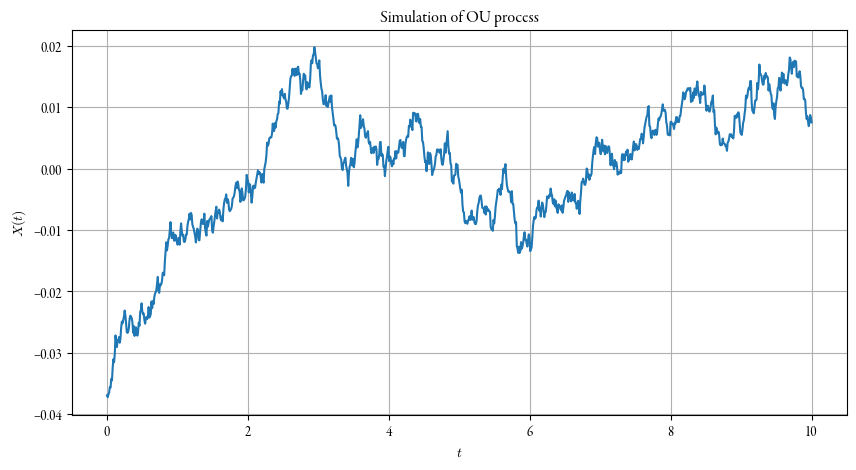

In [3]:
# Parameters
mu = 1     # Drift coefficient
sigma = 0.01   # Diffusion coefficient      # Initial condition
T = 10   # Time horizon
dt = torch.tensor(1e-2, dtype=torch.float)     # Time step size

t, X, dW = generate_OU_data(mu, sigma, t_1=T, dt=dt)

# Plot the training data
fig, ax = plt.subplots(figsize=(10, 5))
ax.grid()
ax.plot(t, X)
ax.set(xlabel='$t$', ylabel='$X(t)$', title='Simulation of OU process');

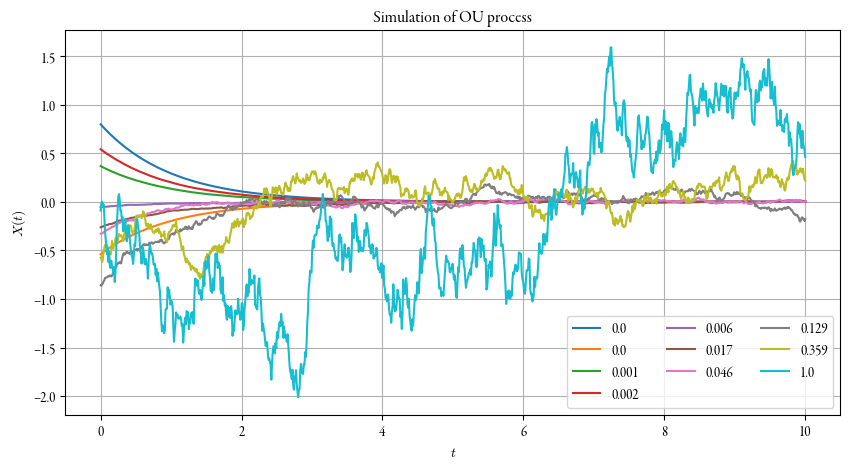

In [4]:
# Parameters
mu = 1     # Drift coefficient
# Plot the training data
fig, ax = plt.subplots(figsize=(10, 5))
ax.grid()
for _sigma in np.logspace(-4, 0, 10):
    t, X, dW = generate_OU_data(mu, _sigma, t_1=T, dt=dt, disable_pbar=True)
    ax.plot(t, X, label=np.round(_sigma, 3))
ax.legend(ncols=3)
ax.set(xlabel='$t$', ylabel='$X(t)$', title='Simulation of OU process');

100%|██████████| 1000/1000 [00:00<00:00, 59887.83it/s]

MLE estimator: 0.6424904465675354


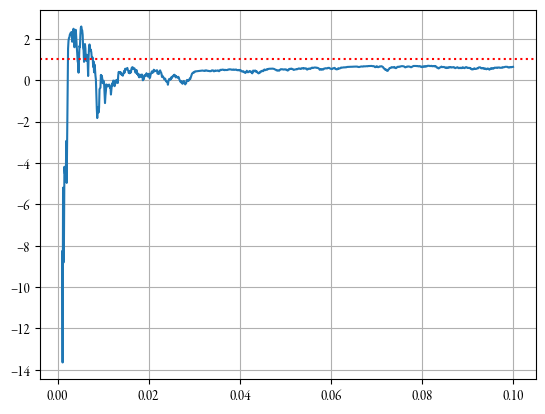

In [8]:
mu_MLE = []
for i in tqdm.tqdm(range(len(X))):
    mu_MLE.append(-(X[i]**2 - X[0]**2 - t[i]) / (2 * torch.sum(X[:i]**2 * dt)))
print(f"MLE estimator: {mu_MLE[-1]}")
fig, ax = plt.subplots()
ax.plot((t * dt)[10:], mu_MLE[10:])
ax.grid()
ax.axhline(mu, ls='dotted', c='red')

In [11]:
# Set up the neural network
def setup_NN():
    return neural_net.NeuralNet(input_size = len(X), 
                              output_size = 2, 
                              activation_funcs=dict(default='sigmoid', layer_specific={-1: 'softplus'}),
                              biases=dict(default=None), 
                              num_layers=5, 
                              nodes_per_layer=dict(default=20),
                              lr=0.002)

In [22]:
def train(_NN, *, training_data, training_dt, n_epochs, batch_size = None, batch_number = None, write_every = 1, 
          training_sigma = 0):
    
    # Batches
    if batch_size:
        batches = np.arange(1, len(training_data)-1, batch_size-1)
        batches = np.append(batches, len(training_data)-1)
        batches = np.append(0, batches)
    
    gen_bs = batch_size is None
    preds, losses = [], []
    
    for _ in tqdm.trange(n_epochs):
        
        _dW = torch.sqrt(dt) * torch.randn(len(training_data))
        
        if gen_bs:
            # Generate random batches
            batches = torch.sort(torch.unique(torch.randint(1, len(training_data)-1, (batch_number-1, )))).values
            batches = np.append(batches, len(training_data)-1)
            batches = np.append(0, batches)

        # Make a prediction
        predicted_drift, predicted_noise = _NN(training_data)
        
        # Simulate the process with the prediction
        for batch_no, start in enumerate(batches[:-1]):
            
            # Upper limit of batch
            stop = batches[batch_no+1]
            
            # Initial value = training data
            predicted_X = [training_data[start].reshape(1, )]
            
            for t, t_val in enumerate(range(start, stop)):
                predicted_X.append(predicted_X[t] - predicted_drift * predicted_X[t] * training_dt + predicted_noise * _dW[t_val])
            predicted_X = torch.stack(predicted_X)
            if predicted_X.shape[0] == 1:
                predicted_X = predicted_X.squeeze(dim=0)
            else:
                predicted_X = predicted_X.squeeze()
            
            # Gradient descent step
            loss = torch.abs(torch.sum(predicted_X[1:]**2) - torch.sum(training_data[start+1:stop+1]**2))  \
                   + torch.nn.functional.mse_loss(predicted_X[1:], training_data[start+1:stop+1], reduction='sum')
            loss.backward()
            _NN.optimizer.step()
            _NN.optimizer.zero_grad()
            
            # Write
            if batch_no % write_every == 0:
                predicted_drift, predicted_noise = _NN(training_data)
                losses.append(loss.clone().detach())
                preds.append(torch.tensor([predicted_drift.clone().detach(), predicted_noise.clone().detach()]))
    return torch.stack(preds).squeeze(), torch.stack(losses)

mu, sigma = 1.2, 0.03
t, X, _ = generate_OU_data(mu, sigma, dt=dt, t_1=5, disable_pbar=True)
NN = setup_NN()
preds, losses = train(NN, training_data=X, training_dt=dt, n_epochs=4000, batch_number=1, training_sigma=0.2)

100%|██████████| 4000/4000 [00:35<00:00, 113.10it/s]


/var/folders/q7/980j630551z68p8jmr50y68r0000gn/T/ipykernel_42553/788099322.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  axs[0].plot(np.array(preds), label=['$\hat{\mu}$', '$\hat{\sigma}$'])
/var/folders/q7/980j630551z68p8jmr50y68r0000gn/T/ipykernel_42553/788099322.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  axs[1].plot(np.array(losses), label='$J$')


[Text(0.5, 0, 'epoch'), None]

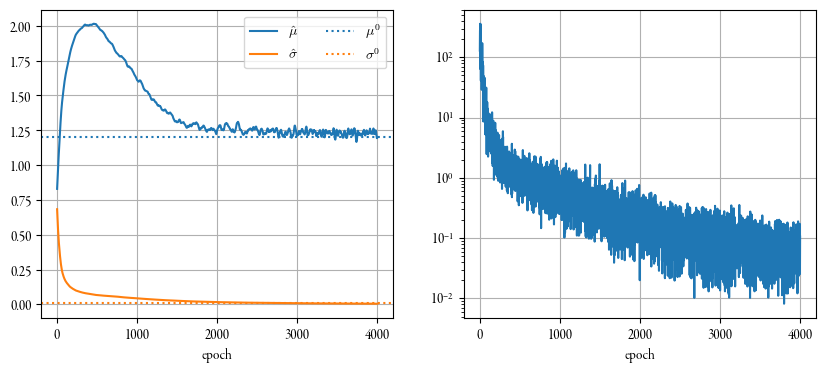

In [21]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharey=False, sharex=False)
axs[0].plot(np.array(preds), label=['$\hat{\mu}$', '$\hat{\sigma}$'])
axs[0].grid()
axs[0].set(xlabel='epoch')
axs[0].axhline(mu, c='C0', ls='dotted', label='$\mu^0$')
axs[0].axhline(sigma, c='C1', ls='dotted', label='$\sigma^0$')
# axs[0].axhline(-(X[-1]**2 - X[0]**2 - t[-1]) / (2 * torch.sum(X**2 * dt)), c='darkgreen', ls='dotted', label='MLE estimate')
axs[0].legend(ncols=2)

axs[1].plot(np.array(losses), label='$J$')
axs[1].grid()
axs[1].set(xlabel='epoch', yscale='log')

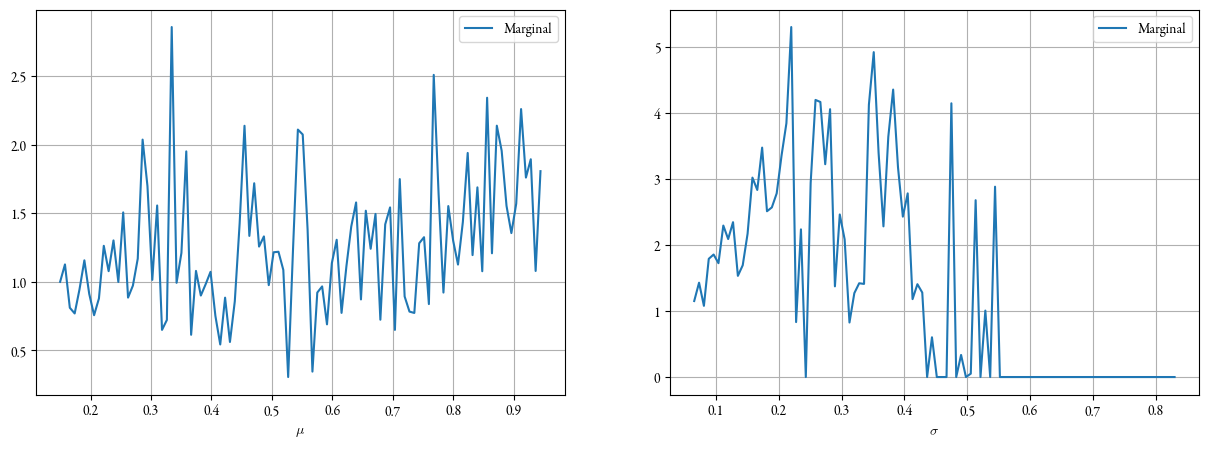

In [158]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

for idx in range(2):
    marginals = marginal_from_ds(xr.Dataset(dict(pred=xr.DataArray(preds.numpy().transpose()[idx], dims=['batch'], coords=dict(batch=np.arange(len(preds)))), loss=xr.DataArray(np.exp(-(losses.numpy() / torch.median(losses))), dims=['batch'], coords=dict(batch=np.arange(len(losses)))))), x='pred', y='loss')
    
    axs[idx].plot(marginals.x.data, marginals.y.data, label='Marginal')
    # axs[idx].axvline(mu if idx == 0 else sigma, c='darkred', ls='dotted', label='$\mu$' if idx==0 else '$\sigma$')
    # ax.axvline(-(X[-1]**2 - X[0]**2 - t[-1]) / (2 * torch.sum(X**2 * dt)), c='darkgreen', ls='dotted', label='MLE estimate')
    axs[idx].legend()
    axs[idx].grid()
    axs[idx].set(xlabel='$\mu$' if idx==0 else '$\sigma$')